### Домашнее задание №1  « Классификация: Логистическая регрессия и SVM»

1. Получите данные и загрузите их в рабочую среду. (Jupyter Notebook или другую)  
2. Проведите первичный анализ. Проверьте данные на пропуски. Удалите в случае обнаружения. Предложите альтернативный способ работы с пропусками
3. Постройте 1-2 графика на выбор. Визуализация должна быть основана на исследуемых данных и быть полезной (из графика можно сделать вывод об особенностях датасета/класса/признака)
4. Преобразуйте категориальные признаки.
5. Разделите выборку на обучающее и тестовое подмножество. 80% данных оставить на обучающее множество, 20% на тестовое.
6. Обучите модели логистической регрессии и опорных векторов на обучающем множестве.
7. Для тестового множества предскажите уровень дохода и сравните с истинным значением, посчитав точность предсказания моделей. Для этого используйте встроенную функцию score.
8. Сформулируйте выводы по проделанной работе.
9. Кратко опишите какие преобразования были сделаны с данными.
10. Сравните точность двух моделей.
11. Напишите свое мнение, в полной ли мере модели справились с поставленной задачей. Что по вашему мнению нужно сделать, чтобы улучшить результат ?
----
*Результат: получены базовые знания по подготовке данных к работе с моделями машинного обучения. Построено 2 модели классификации, сделан вывод о целесообразности их применения к данным.
Форма выполнения: ссылка на Jupyter Notebook, загруженный на GitHub; ссылка на Google Colab; файл с расширением .ipynb.*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import sample, seed
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix)
palette = 'magma_r'
pal = sns.color_palette(palette)
seed(1)

In [2]:
data = pd.read_csv('Downloads/adult.csv', na_values='?')

### 1. Предобработка данных

In [3]:
display(data.head())
display(data.shape)
data.info()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


(48842, 15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        46043 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       46033 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   47985 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


Проверяем наличие дубликатов и удаляем, если есть.

In [4]:
print(f'В датафрейме выявлено {data.duplicated().sum()} дубликатов')

В датафрейме выявлено 52 дубликатов


In [5]:
data.drop_duplicates(inplace=True)

Пропуски явно есть, проверим где и какие.

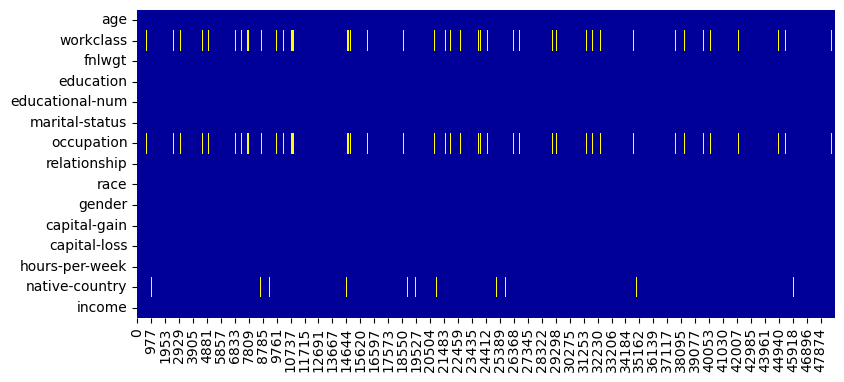

In [6]:
plt.figure(figsize=(9, 4))
colours = ['#000099', '#ffff00'] 
sns.heatmap(data[data.columns].isnull().T, cmap=sns.color_palette(colours), cbar=False)
plt.show()

In [7]:
pd.concat([data.isnull().sum().rename('cnt'), round((data.isna().mean() * 100),2).rename('%')], axis=1)

,cnt,%
age,0,0.00
workclass,2795,5.73
fnlwgt,0,0.00
education,0,0.00
educational-num,0,0.00
marital-status,0,0.00
occupation,2805,5.75
relationship,0,0.00
race,0,0.00
gender,0,0.00


1. Пропуски в данных по стране занимают меньше 2% данных. Вряд ли можно подобрать какую либо адекватную взаимосвязь с другими данными, по этому просто удалим эти строки.  
2. Пропуски в рабочем классе и занятости занимают по 6% и видимо в одних и тех же строках. Можно попробовать заполнить их модами сгруппированных объектов наблюдения по __образованию, семейному положению и недельной занятости__.

In [8]:
data.groupby(['education',
              'marital-status',
              'hours-per-week'])['workclass'].agg(lambda x: x.mode()).to_frame().reset_index()

,education,marital-status,hours-per-week,workclass
0,10th,Divorced,1,Private
1,10th,Divorced,7,[]
2,10th,Divorced,10,Self-emp-not-inc
3,10th,Divorced,12,[]
4,10th,Divorced,16,Private
...,...,...,...,...
2640,Some-college,Widowed,55,Private
2641,Some-college,Widowed,60,Private
2642,Some-college,Widowed,62,Private
2643,Some-college,Widowed,70,"[Private, Self-emp-inc]"


Иногда в таких группах могут быть больше 1 моды, иногда ни одной. Попробуем избавиться от мультимодальности случайным выбором единственной моды либо ничего.  
Заполним по такой логике пропуски. Все что не заполнилось удалим.

In [9]:
random_mode = lambda x: sample(list(x.mode()),1)[0] if x.count() !=0 else np.nan

In [10]:
data.loc[data['workclass'].isna(), 'workclass'] = data.groupby(['education', 
                                                                'marital-status',
                                                                'hours-per-week'])['workclass'].transform(random_mode)
data.loc[data['occupation'].isna(), 'occupation'] = data.groupby(['education', 
                                                                  'marital-status',
                                                                  'hours-per-week'])['occupation'].transform(random_mode)

In [11]:
pd.concat([data.isnull().sum().rename('cnt'), round((data.isna().mean() * 100),2).rename('%')], axis=1)

,cnt,%
age,0,0.00
workclass,148,0.30
fnlwgt,0,0.00
education,0,0.00
educational-num,0,0.00
marital-status,0,0.00
occupation,148,0.30
relationship,0,0.00
race,0,0.00
gender,0,0.00


In [12]:
data.dropna(inplace=True)

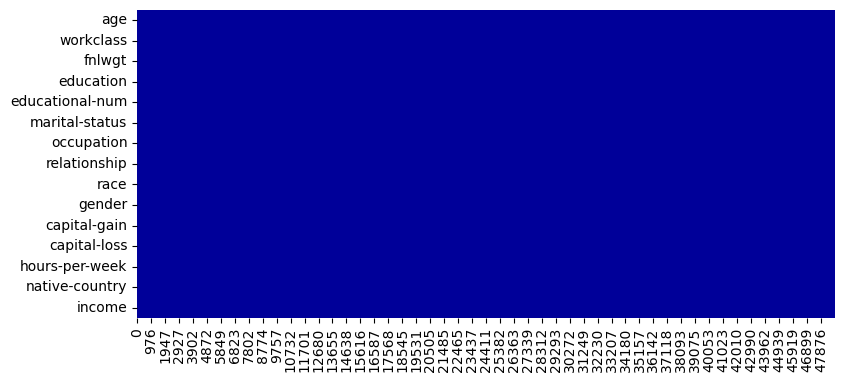

In [13]:
plt.figure(figsize=(9, 4))
colours = ['#000099', '#ffff00'] 
sns.heatmap(data[data.columns].isnull().T, cmap=sns.color_palette(colours), cbar=False)
plt.show()

Пропусков и дублей нет

### 2. EDA

Выведем графики для категориальных и числовых столбцов

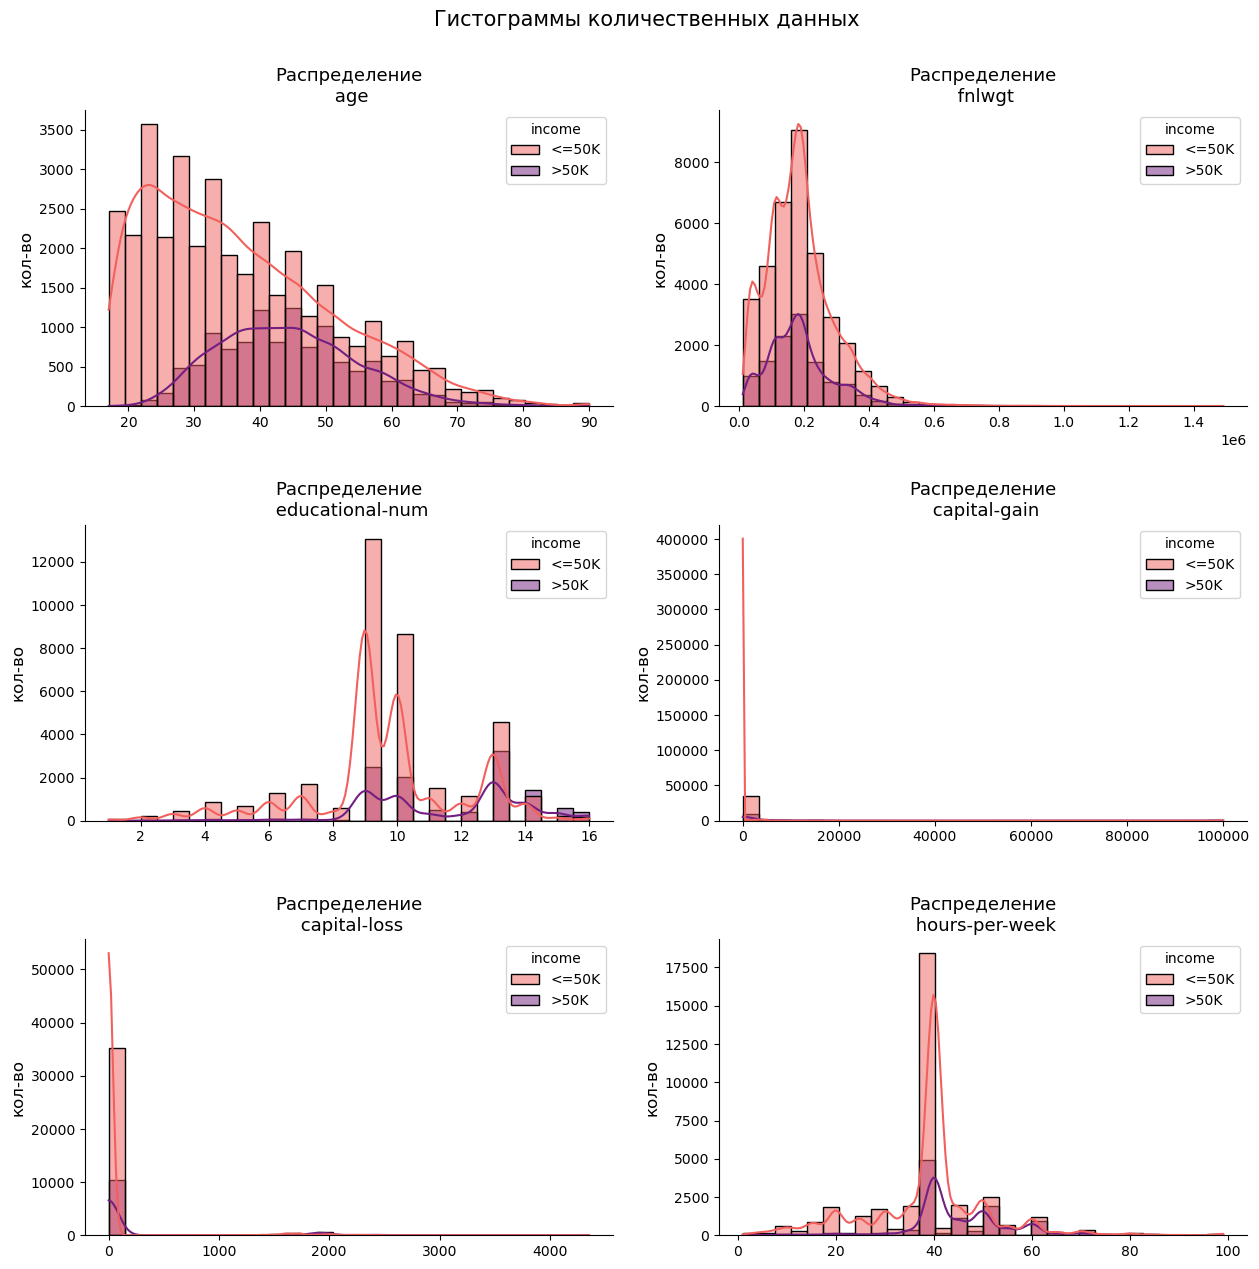

In [14]:
fig = plt.figure(figsize=(15,20))
cols = [k for k,v in data.dtypes.to_dict().items() if v == "int"]
for i,col in enumerate(cols):
    fig.add_subplot(4, 2, i+1)
    sns.histplot(data=data, x=col, palette=palette, hue='income', kde=True, bins=30)
    plt.title(f'Распределение\n {col}', size=13)
    plt.xlabel('', size=12)
    sns.despine()
    plt.ylabel('кол-во', size=12)
plt.suptitle('Гистограммы количественных данных', size=15, y=0.93)
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()

1. По возрасту распределение ожидаемое. Люди помоложе обладают меньшим доходом, а у зарабатывающих свыше 50К распределение по возрасту нормально.  
2. Показатель fnlwgt не понятно что означает, но распределен у двух признаков одинаково
3. Уровень образования чаще всего среднее и выше, зарабатывающие свыше 50К более образованы.
5. Уровни прироста и оттока капитала чаще всего нулевые за очень редким исключением
6. Недельная занятость на уровне 40 часов в неделю, зарабатывающие свыше 50К больше работают

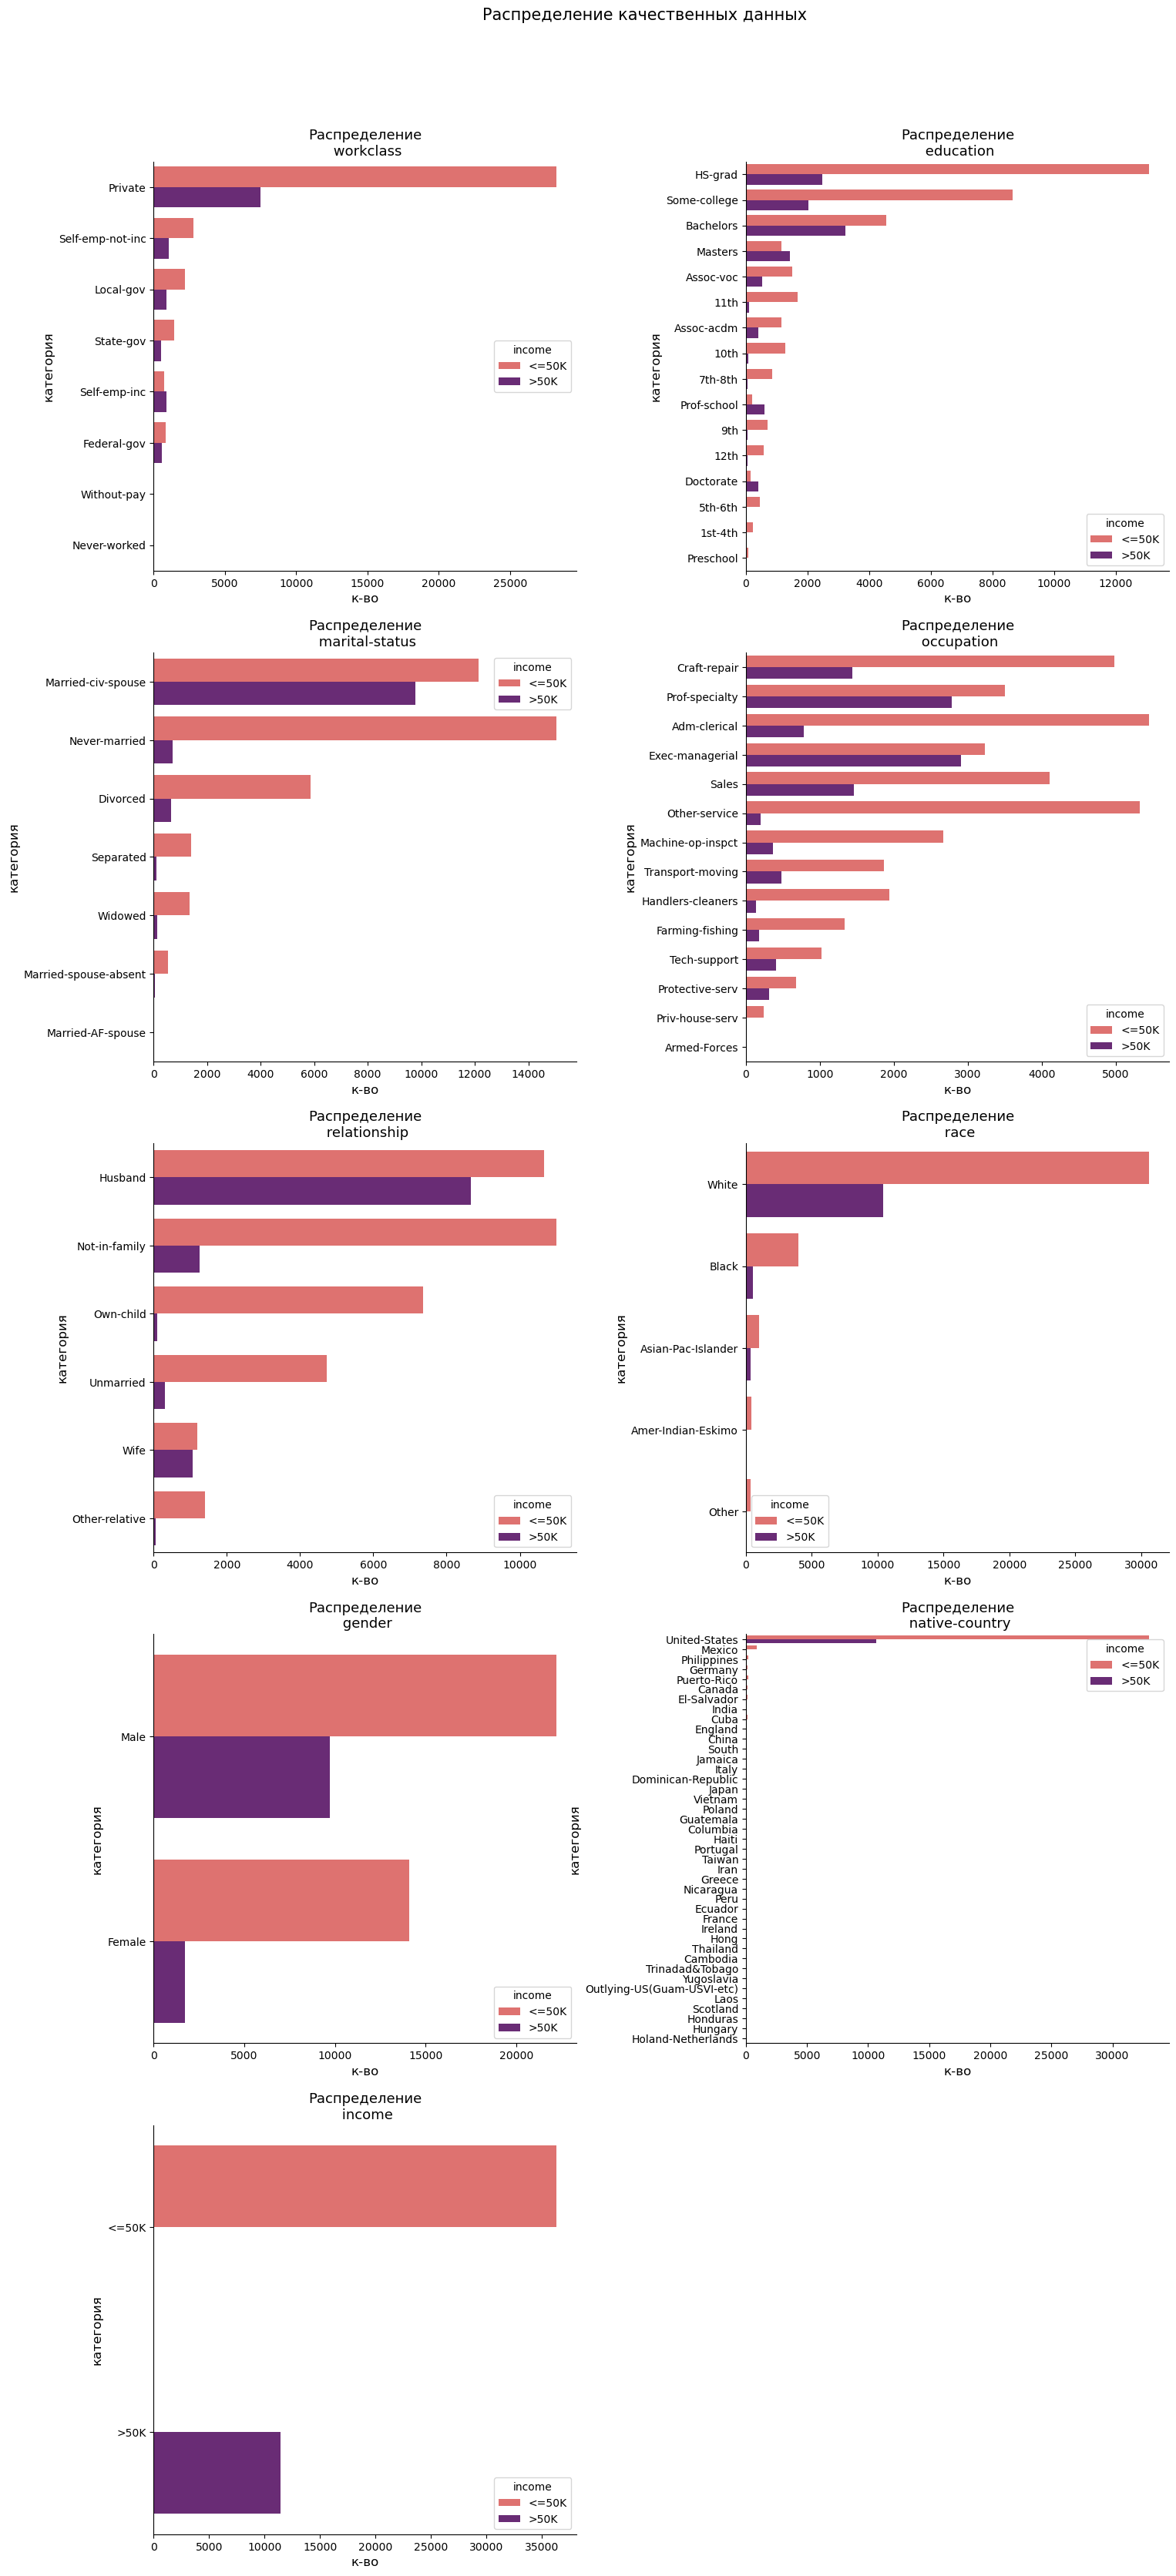

In [15]:
fig = plt.figure(figsize=(17,40))
cols = [k for k,v in data.dtypes.to_dict().items() if v == "object"]
for i,col in enumerate(cols):
    fig.add_subplot(5, 2, i+1)
    sns.countplot(data=data, y=col, order = data[col].value_counts().index,palette=palette, hue='income', linewidth=1)
    plt.title(f'Распределение\n {col}', size=13)
    plt.xlabel('к-во', size=12)
    sns.despine()
    plt.ylabel('категория', size=12)
plt.suptitle('Распределение качественных данных', size=15, y=0.93)
plt.subplots_adjust(wspace=0.4, hspace=0.2)
plt.show()

Распределения закономерны. Особое внимание стоит уделить дисбалансу мужчин и женщин. Практически все объекты из США. Целевая переменная так же не сбалансированная, но это нормально - богачей обычно меньше.

### 3. Классификация

Сперва заменим все строковые данные числами. Стратегию `get_dummies` подготовим, но использовать пока не будем, сперва попробуем воспользоваться `LabelEncoder`.  Целевую переменную закодируем таким образом, чтобы в первую очередь детектить тех у кого доходы __<=50K__

In [16]:
# data = pd.get_dummies(data=data, columns=['relationship', 'race']).copy()

In [17]:
data['income'] = data['income'].map({'>50K': 0, '<=50K': 1})

In [18]:
le = LabelEncoder()

In [19]:
for item in [k for k,v in data.dtypes.to_dict().items() if v == "object"]:
    le.fit(data[item])
    data[item] = le.transform(data[item])

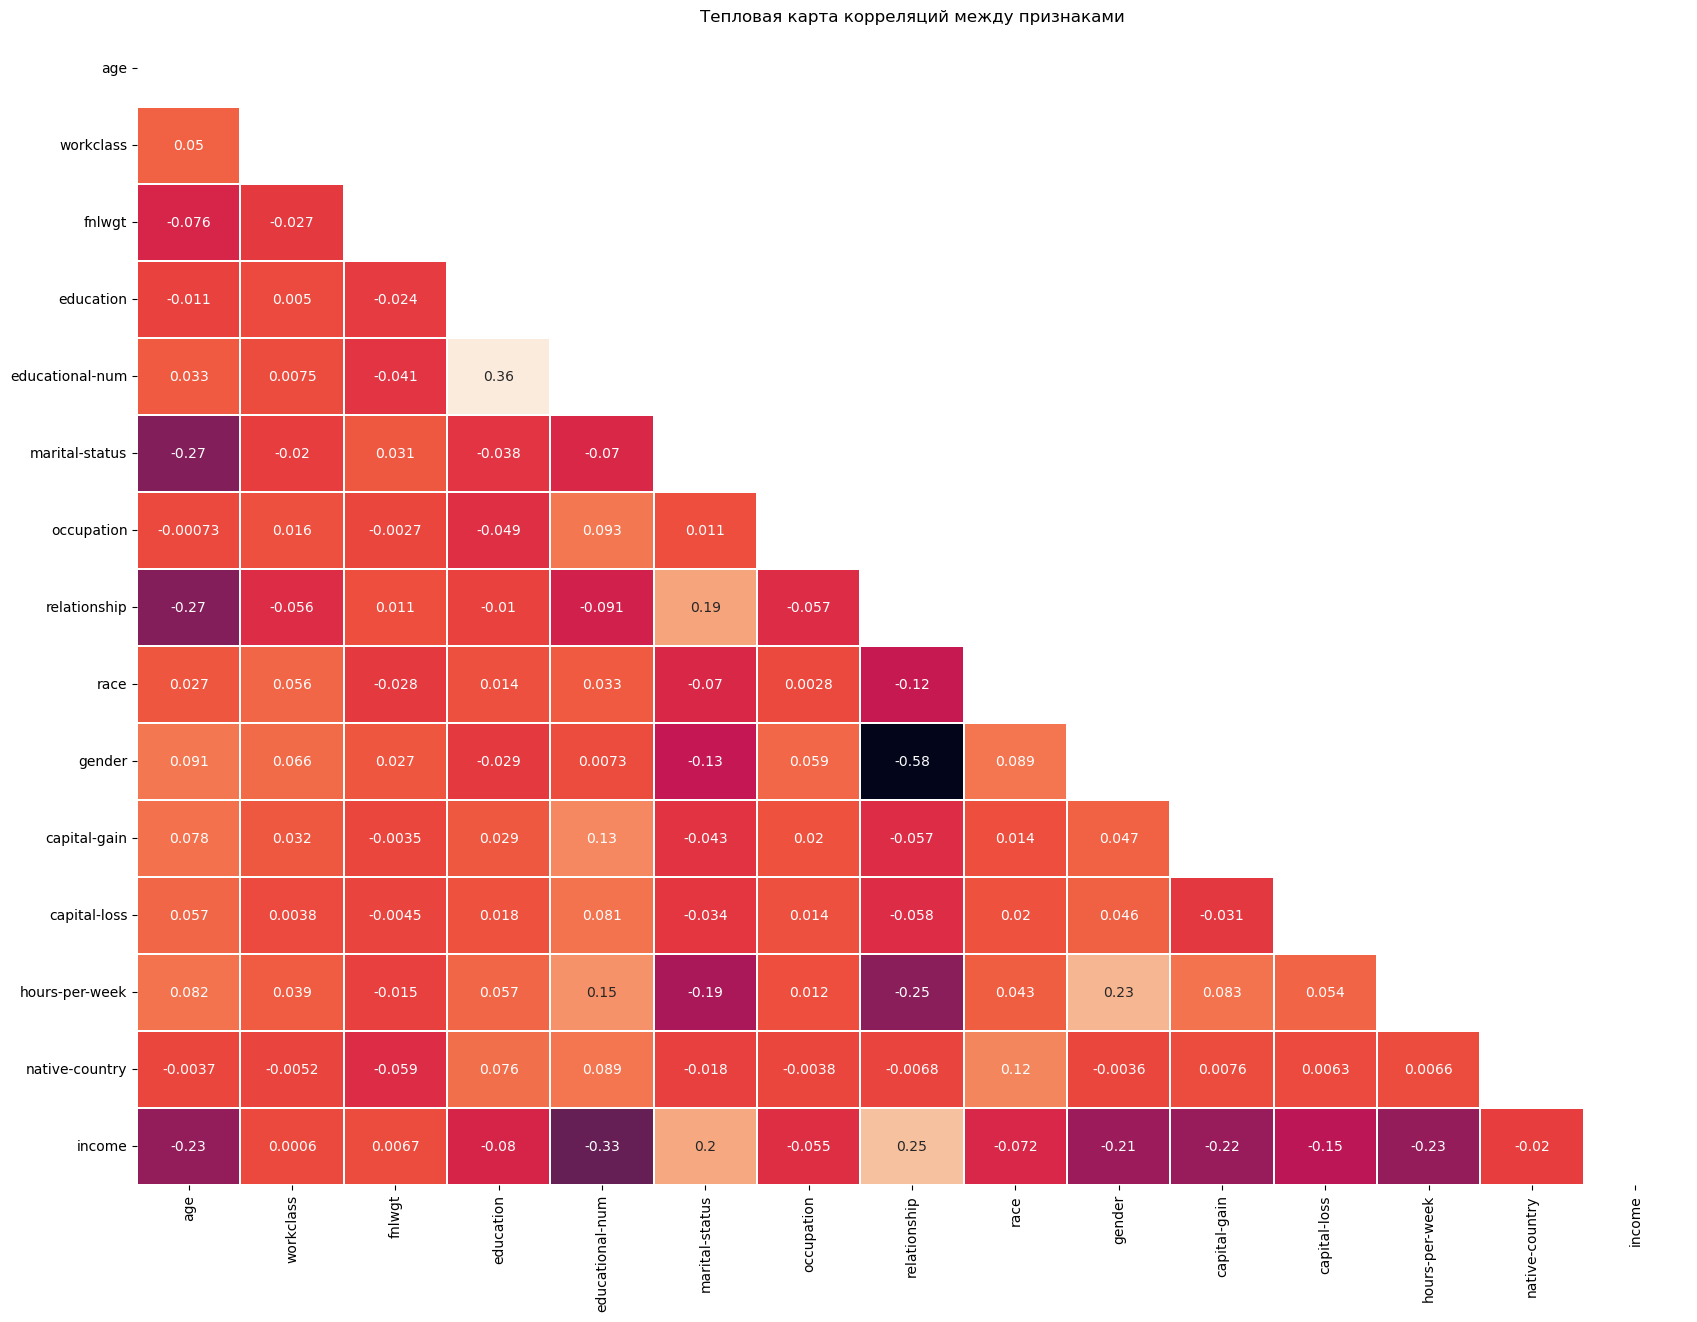

In [20]:
fig = plt.figure(figsize=(20,15))
mask = np.triu(data.corr())
sns.heatmap(data.corr(), annot=True, fmt='.2g', mask=mask, linecolor = 'white', linewidths=0.3, cbar=False)
plt.title('Тепловая карта корреляций между признаками')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

Признаки не особо коррелируют. 
Попробуем обучить и проверить модели __Логистической регрессии и SVM__. Дополнительно сравним с другими моделями (выходят за рамки задания).  
Т.к. целевая переменная разбалансировнна, добавим этот параметр в модели

In [21]:
def make_prediction(m, df, target):
    '''
    ФУНКЦИЯ ДЛЯ ПРЕДСКАЗАНИЙ
    ---------------------------
    На вход подается название модели, датафрейм, название столбца с целевой переменной
    Внутри происходит следующее:
    1) Датафрейм делится на признаки и Целевую переменную
    2) Выборка делится на обучающую и валидационную 80/20
    3) Обучающая выборка z преобразуется (средняя=0, std=1)
    4) Обучаем модель на преобразованной выборке
    5) Выдаем тестовый вектора целевой переменной, предсказаний целевой переменной и accuracy на тренировочной и тестовой выборках
    '''
    y = df[target]
    X = df.drop([target], axis = 1) 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    model = m
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_st = scaler.transform(X_train)
    X_test_st = scaler.transform(X_test)
    model.fit(X_train_st, y_train)
    y_pred = model.predict(X_test_st)
    score_train = model.score(X_train_st, y_train)
    score_test = model.score(X_test_st, y_test)

    return y_test, y_pred, score_train, score_test

In [22]:
def metrics_dict(y_true, y_pred):
    '''
    ФУНКЦИЯ ДЛЯ РАСЧЕТА МЕТРИК
    ---------------------------
    На вход подаются вектора истиной целевой переменной, 
    предсказанной целевой переменной.
    В результате выводятся: Матрица ошибок, Accuracy, Precision, Recall, F1
    '''
    metrics = {}
    metrics['Accuracy'] = (accuracy_score(y_true, y_pred))
    metrics['Precision'] = (precision_score(y_true, y_pred))
    metrics['Recall'] = (recall_score(y_true, y_pred))
    metrics['F1'] = (f1_score(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(f'true negative = {tn}\nfalse positive = {fp}\nfalse negative = {fn}\ntrue positive = {tp}')
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Матрица ошибок')
    plt.show()
    display(pd.Series(metrics))

In [23]:
def model_report(model):
    print(model,'\n')
    res = make_prediction(model, data, 'income')
    print(f'Accuracy на тренировочной выборке = {res[2]}')
    print(f'Accuracy на тестовой выборке = {res[3]}')
    metrics_dict(res[0], res[1])

LogisticRegression(class_weight='balanced') 

Accuracy на тренировочной выборке = 0.768997358026629
Accuracy на тестовой выборке = 0.769407825905001
true negative = 1761
false positive = 505
false negative = 1699
true positive = 5593


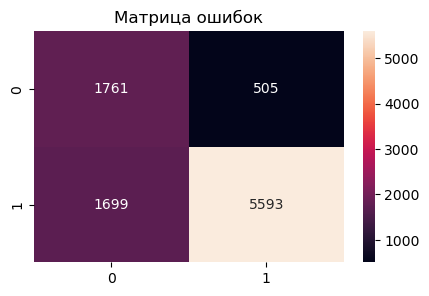

Accuracy     0.769408
Precision    0.917186
Recall       0.767005
F1           0.835400
dtype: float64

In [24]:
model_report(LogisticRegression(class_weight='balanced'))

SVC(class_weight='balanced') 

Accuracy на тренировочной выборке = 0.8006487221742656
Accuracy на тестовой выборке = 0.7911697007742206
true negative = 1986
false positive = 280
false negative = 1716
true positive = 5576


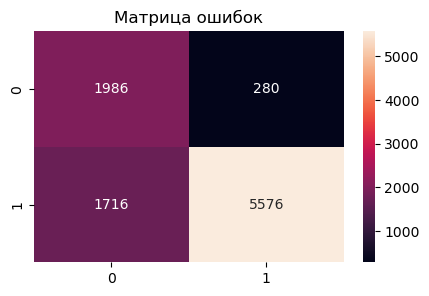

Accuracy     0.791170
Precision    0.952186
Recall       0.764674
F1           0.848190
dtype: float64

In [25]:
model_report(SVC(class_weight='balanced'))

DecisionTreeClassifier(class_weight='balanced') 

Accuracy на тренировочной выборке = 0.9998953673912475
Accuracy на тестовой выборке = 0.8213015275162168
true negative = 1417
false positive = 849
false negative = 859
true positive = 6433


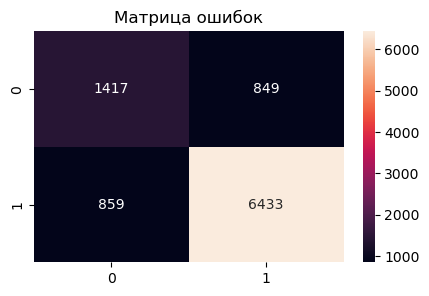

Accuracy     0.821302
Precision    0.883411
Recall       0.882200
F1           0.882805
dtype: float64

In [26]:
model_report(DecisionTreeClassifier(class_weight='balanced'))

RandomForestClassifier(class_weight='balanced') 

Accuracy на тренировочной выборке = 0.9998692092390593
Accuracy на тестовой выборке = 0.8618957940991839
true negative = 1446
false positive = 820
false negative = 500
true positive = 6792


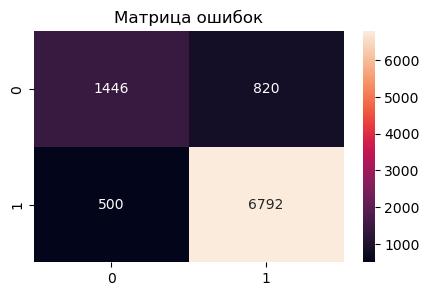

Accuracy     0.861896
Precision    0.892275
Recall       0.931432
F1           0.911433
dtype: float64

In [27]:
model_report(RandomForestClassifier(class_weight='balanced'))

GradientBoostingClassifier() 

Accuracy на тренировочной выборке = 0.8665149493839756
Accuracy на тестовой выборке = 0.8691148775894538
true negative = 1360
false positive = 906
false negative = 345
true positive = 6947


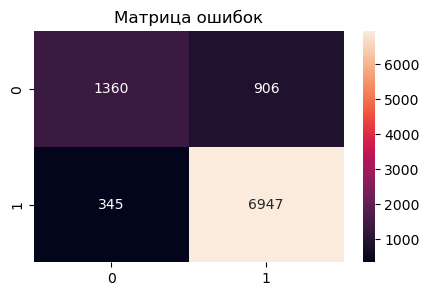

Accuracy     0.869115
Precision    0.884630
Recall       0.952688
F1           0.917398
dtype: float64

In [28]:
model_report(GradientBoostingClassifier())

__Confusion matrix__ Матрица ошибок - это комбинация результатов
* True Positive («истинно положительные») — TP.
* False Positive («ложно положительные») — FP.
* False Negative («ложно отрицательные») — FN.
* True Negative («истинно отрицательные») — TN.  
У хорошей модели бóльшая часть прогнозов должна попадать в группы TP и TN.


__Accuracy__ - Это доля верно угаданных ответов из всех прогнозов. Чем ближе к единице, тем лучше.  

$$ Accuracy = {{TP + TN }\over {TP + TN + FP + FN}} $$



__Precision__ (точность) говорит, какая доля прогнозов относительно "1" класса верна. То есть смотрим долю правильных ответов только среди целевого класса. В бизнесе метрика precision нужна, если каждое срабатывание (англ. alert) модели — факт отнесения к классу "1" — стоит ресурсов. Принимает значение от 0 до 1. Чем ближе к единице, тем лучше.

$$ Precision = {{TP}\over {TP + FP}} $$




__Recall__ (полнота) показывает, сколько реальных объектов "1" класса мы смогли обнаружить с помощью модели. Эта метрика полезна если мы стараемся избежать ошибки второго рода.  Принимает значение от 0 до 1. Чем ближе к единице, тем лучше.

$$ Recall = {{TP}\over {TP + FN}} $$



Так как __precision__ и __recall__ направлены на избежание противоположных рисков, нужна сводная метрика, учитывающая баланс между метриками. Это __F1-score__. Принимает значение от 0 до 1. Чем ближе к единице, тем лучше.   

$$ F1 = {{2 * Precision * Recall}\over {Precision + Recall}} $$

### Выводы:  

Сравнивая __логистическую регрессию (ЛР)__ и __SVM__ можно отметить что обе не особо переобучаются. По метриками обе похожи, но вторая слегка лучше, хотя хуже предсказывает объекты с низким доходом.

Так называемые __"деревянные"__ модели лучше по метрикам, но склонны к переобучению.  

Лучше всех себя показал __градиентный бустинг__. И по переобучению, и по предсказанию 1 класса, и по сводной метрике F1
_____
В целом модель хороша, но не идеальна. 13% предсказаний все же не верны.  

Улучшить качество модели скорее всего можно более тонкой настройкой параметров либо корректировкой баланса повысить качество предсказаний одного класса за счет другого (зависит от бизнес задачи)